In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os


In [15]:
data_dir =r"C:\Users\user\Downloads\Project\Machine-Learning-Supervised-learning-and-Unsupervised-Learning\Raqib's (Unsupervised Learning)\Data_LCP"
img_size = (128, 128)


In [13]:
images = []
labels = []

valid_ext = (".jpg", ".jpeg", ".png")

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):

            # Skip non-image files
            if not img_name.lower().endswith(valid_ext):
                continue

            img_path = os.path.join(class_path, img_name)

            img = cv2.imread(img_path)

            if img is None:
                print("Skipped:", img_path)
                continue

            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            images.append(img.flatten())
            labels.append(class_name)
print("Total images loaded:", len(images))
print("Unique labels:", set(labels))


Total images loaded: 298
Unique labels: {'Smartphone', 'PC', 'Laptop'}


In [16]:
import numpy as np

# images & labels already filled by your loop
X = np.array(images, dtype=np.float32)

# normalize pixels (0–1)
X = X / 255.0

print("X shape:", X.shape)
print("Number of samples:", len(X))
print("Example labels:", labels[:5])


X shape: (298, 16384)
Number of samples: 298
Example labels: ['Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop']


In [17]:
# Assuming we have 3 device types: Laptop, PC, Smartphone
k = 3  # Laptop, PC, Smartphone
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

clusters = kmeans.fit_predict(X)

print("First 10 cluster labels:", clusters[:10])


First 10 cluster labels: [1 2 2 1 2 2 2 1 1 0]


In [18]:
# Create a DataFrame to compare actual labels with cluster assignments
unique, counts = np.unique(clusters, return_counts=True)
for c, n in zip(unique, counts):
    print(f"Cluster {c}: {n} images")


Cluster 0: 96 images
Cluster 1: 88 images
Cluster 2: 114 images


In [19]:
# Create a DataFrame to compare actual labels with cluster assignments
df = pd.DataFrame({
    "actual_label": labels,
    "cluster": clusters
})

crosstab = pd.crosstab(df["actual_label"], df["cluster"])
print(crosstab)


cluster        0   1   2
actual_label            
Laptop        35  27  52
PC            27  52   8
Smartphone    34   9  54


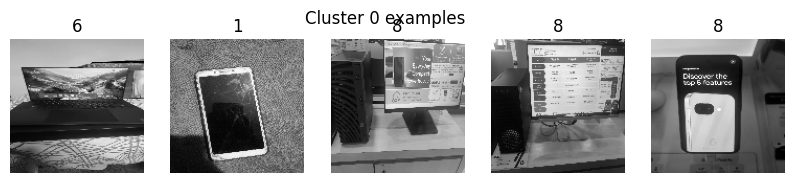

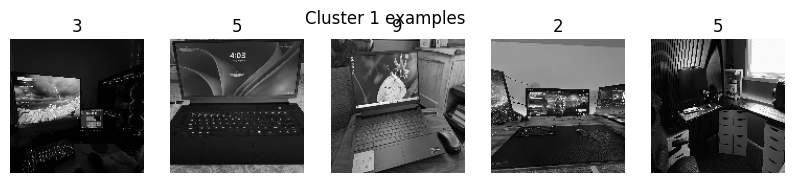

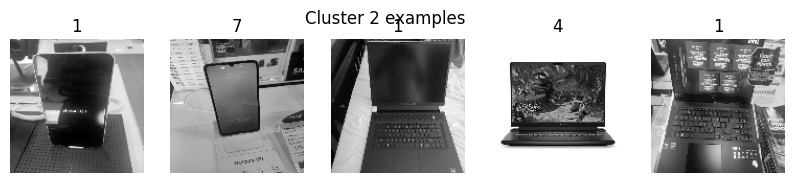

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

In [29]:
# Visualize some examples from each cluster
import matplotlib.pyplot as plt

img_size = (128, 128)  # same as before

def show_examples_for_cluster(cluster_id, n=5):
    cluster_indices = np.where(clusters == cluster_id)[0]
    idxs = np.random.choice(cluster_indices, size=min(n, len(cluster_indices)), replace=False)
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(idxs):
        img = X[idx].reshape(img_size)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(labels[idx])
    plt.suptitle(f"Cluster {cluster_id} examples")
    plt.show()

for c in range(k):
    show_examples_for_cluster(c, n=5)


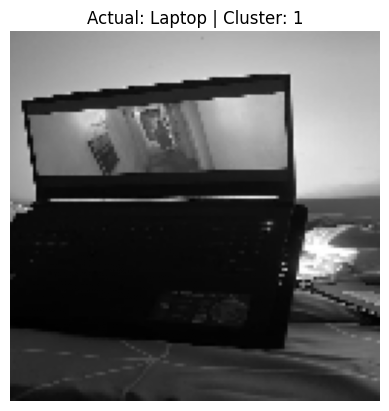

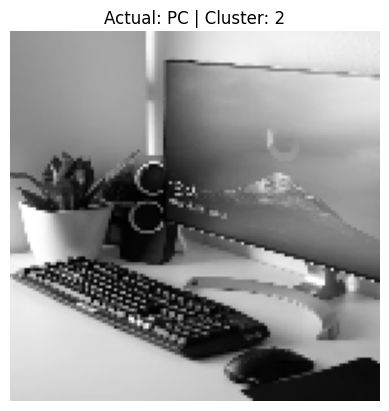

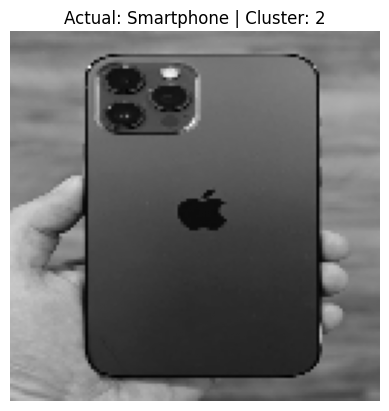

In [21]:
# Show one representative image from each actual class with its cluster assignment
classes = sorted(list(set(labels)))  # ['Laptop', 'PC', 'Smartphone']
representative_indices = {}

for cls in classes:
    for i, lbl in enumerate(labels):
        if lbl == cls:
            representative_indices[cls] = i
            break

for cls, idx in representative_indices.items():
    img = X[idx].reshape(img_size)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Actual: {cls} | Cluster: {clusters[idx]}")
    plt.show()


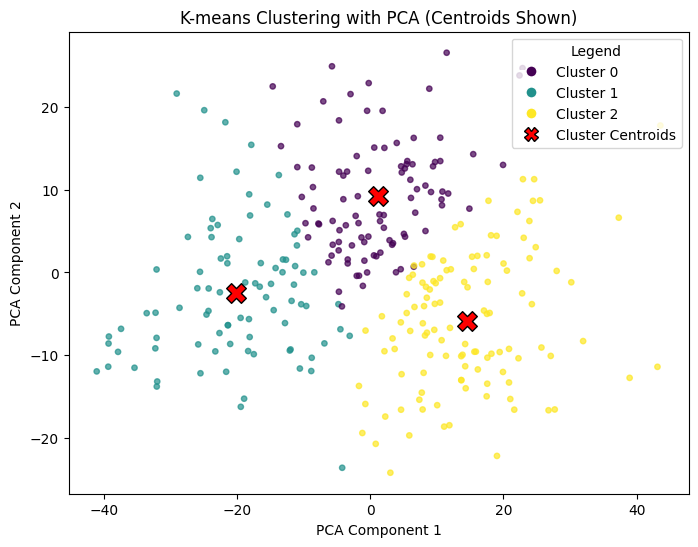

In [22]:
# PCA transformation
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)

centroids = kmeans.cluster_centers_
centroids_2d = pca.transform(centroids)

plt.figure(figsize=(8,6))

# Scatter plot of data points colored by cluster
scatter = plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=clusters,
    cmap='viridis',
    s=15,
    alpha=0.7
)

# Centroids (red X)
plt.scatter(
    centroids_2d[:,0], centroids_2d[:,1],
    marker='X',
    s=200,
    color='red',
    edgecolors='black'
)

# ---- CLEAN LEGEND ----
legend_elements = [
    Line2D([0],[0], marker='o', color='w', label='Cluster 0',
           markerfacecolor=scatter.cmap(scatter.norm(0)), markersize=8),
    Line2D([0],[0], marker='o', color='w', label='Cluster 1',
           markerfacecolor=scatter.cmap(scatter.norm(1)), markersize=8),
    Line2D([0],[0], marker='o', color='w', label='Cluster 2',
           markerfacecolor=scatter.cmap(scatter.norm(2)), markersize=8),
    Line2D([0],[0], marker='X', color='w', label='Cluster Centroids',
           markerfacecolor='red', markeredgecolor='black', markersize=10)
]

plt.legend(handles=legend_elements, title="Legend")

plt.title("K-means Clustering with PCA (Centroids Shown)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [23]:
# Range of k values to test
k_values = range(1, 11)   # k = 1 to 10
sse = []                  # SSE / inertia for each k

for k in k_values:
    kmeans_tmp = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_tmp.fit(X)
    sse.append(kmeans_tmp.inertia_)   # inertia_ = sum of squared distances to closest centroid

# Show numeric values (optional, nice for table in report)
for k, j in zip(k_values, sse):
    print(f"k = {k}: SSE = {j:.2f}")


k = 1: SSE = 326620.72
k = 2: SSE = 271426.22
k = 3: SSE = 253190.81
k = 4: SSE = 240749.28
k = 5: SSE = 232730.19
k = 6: SSE = 226914.11
k = 7: SSE = 222209.30
k = 8: SSE = 217423.83
k = 9: SSE = 215311.56
k = 10: SSE = 211206.78


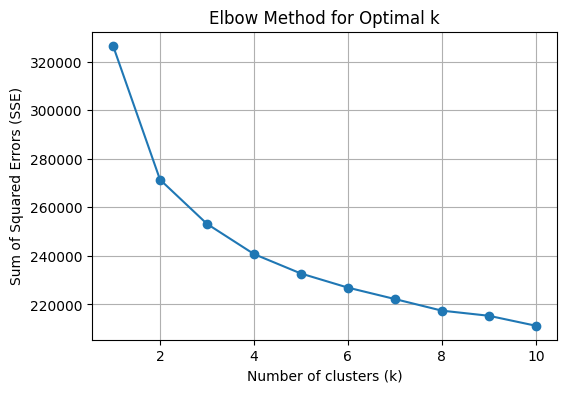

In [24]:
plt.figure(figsize=(6,4))
plt.plot(k_values, sse, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.grid(True)
plt.show()


In [25]:
sil_score = silhouette_score(X, clusters)
print("Silhouette score:", sil_score)


Silhouette score: 0.10279948264360428


In [26]:
def kmeans_with_history(X, k=3, max_iters=20, random_state=42):
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]

    # 1) random init: choose k points as centroids
    indices = rng.choice(n_samples, size=k, replace=False)
    centroids = X[indices].copy()

    centroids_history = [centroids.copy()]   # centroids at each iteration (including init)
    assignments_history = []                 # labels at each iteration
    objective_history = []                   # J at each iteration

    for it in range(max_iters):
        # 2) distances from every point to every centroid
        dists = np.linalg.norm(
            X[:, None, :] - centroids[None, :, :],
            axis=2
        )  # shape (n_samples, k)

        labels = np.argmin(dists, axis=1)

        # 3) objective function J = sum of squared distances
        J = np.sum((X - centroids[labels]) ** 2)
        objective_history.append(J)
        assignments_history.append(labels)

        # 4) recompute centroids
        new_centroids = []
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) == 0:
                # if cluster is empty, keep old centroid
                new_centroids.append(centroids[j])
            else:
                new_centroids.append(cluster_points.mean(axis=0))
        new_centroids = np.vstack(new_centroids)

        centroids_history.append(new_centroids.copy())

        # 5) convergence check
        if np.allclose(new_centroids, centroids):
            print(f"Converged at iteration {it+1}")
            break

        centroids = new_centroids

    return assignments_history, centroids_history, objective_history

# run on YOUR data
k = 3
assignments_history, centroids_history, objective_history = kmeans_with_history(X, k=k, max_iters=20)
print("Iterations:", len(objective_history))


Converged at iteration 9
Iterations: 9


In [27]:
# Reduce to 2D for plotting
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)
centroids_history_2d = [pca.transform(C) for C in centroids_history]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
cmap = plt.cm.get_cmap('viridis', k)

# --- Left: clustering process ---
init_assign = assignments_history[0]
init_centroids = centroids_history_2d[0]

sc = ax1.scatter(X_2d[:, 0], X_2d[:, 1],
                 c=init_assign, cmap=cmap, s=20, vmin=0, vmax=k-1)
centroid_sc = ax1.scatter(init_centroids[:, 0], init_centroids[:, 1],
                          marker='X', s=120, c='red', edgecolors='black')
iter_text = ax1.text(0.02, 0.95, "", transform=ax1.transAxes,
                     fontsize=12, color='black', weight='bold')

ax1.set_title("K-means Clustering Process (PCA 2D)")
ax1.set_xlabel("PCA Component 1")
ax1.set_ylabel("PCA Component 2")

# --- Right: objective function J(K) ---
ax2.set_xlim(1, len(objective_history))
ax2.set_ylim(0, max(objective_history) * 1.05)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Objective Function J")
ax2.set_title("Objective Function Convergence")
line_loss, = ax2.plot([], [], 'b-o')
text_loss = ax2.text(0.02, 0.93, "", transform=ax2.transAxes,
                     fontsize=11, color='darkred', va='top')

def update(frame):
    # frame index corresponds to iteration
    assignments = assignments_history[frame]
    centroids_2d = centroids_history_2d[frame+1]
    J = objective_history[frame]

    # update clustering view
    sc.set_array(assignments.astype(float))
    centroid_sc.set_offsets(centroids_2d)
    iter_text.set_text(f"Iteration: {frame+1}")

    # update J curve
    x_vals = np.arange(1, frame+2)
    y_vals = objective_history[:frame+1]
    line_loss.set_data(x_vals, y_vals)
    text_loss.set_text(f"J = {J:.2f}")

    return sc, centroid_sc, line_loss, text_loss, iter_text

anim = FuncAnimation(
    fig, update,
    frames=len(objective_history),
    interval=800,
    blit=True,
    repeat=False
)

plt.close(fig)      # avoid double static plot
HTML(anim.to_jshtml())


C:\Users\user\AppData\Local\Temp\ipykernel_30468\1295071783.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', k)


In [28]:
# Range of k values to test
k_values = range(2, 11)   # start at 2 (silhouette cannot do k=1)
sse = []
sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X)
    
    # SSE / inertia
    sse.append(kmeans.inertia_)
    
    # Silhouette Score
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)
    
    print(f"k = {k}: SSE = {kmeans.inertia_:.2f} | Silhouette = {sil:.3f}")

k = 2: SSE = 271426.22 | Silhouette = 0.148
k = 3: SSE = 253190.81 | Silhouette = 0.103
k = 4: SSE = 240749.28 | Silhouette = 0.084
k = 5: SSE = 232730.19 | Silhouette = 0.081
k = 6: SSE = 226914.11 | Silhouette = 0.073
k = 7: SSE = 222209.30 | Silhouette = 0.063
k = 8: SSE = 217423.83 | Silhouette = 0.068
k = 9: SSE = 215311.56 | Silhouette = 0.053
k = 10: SSE = 211206.78 | Silhouette = 0.052


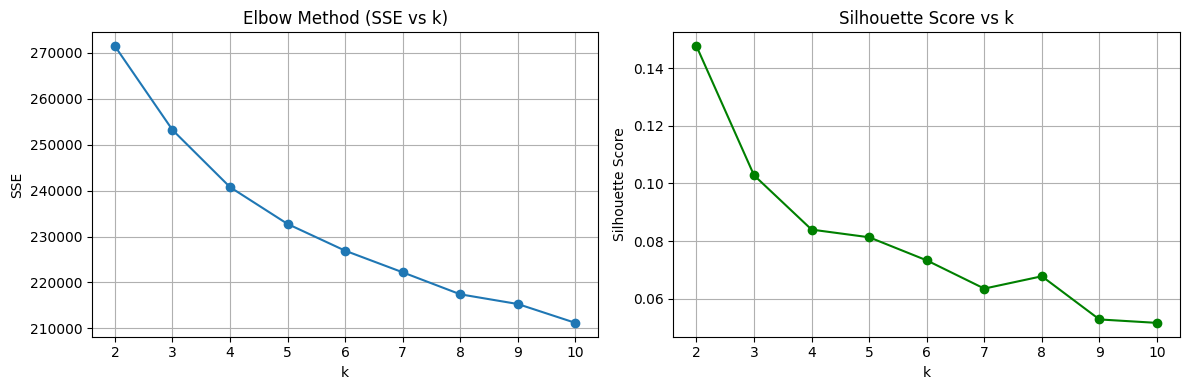

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Elbow
ax[0].plot(k_values, sse, marker="o")
ax[0].set_title("Elbow Method (SSE vs k)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("SSE")
ax[0].grid(True)

# Silhouette
ax[1].plot(k_values, sil_scores, marker="o", color="green")
ax[1].set_title("Silhouette Score vs k")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette Score")
ax[1].grid(True)

plt.tight_layout()
plt.show()

